<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150> <br>
<font color=0F5298 size=7>
Artificial Intelligence <br>
<font color=2565AE size=5>
Computer Engineering Department <br>
FALL 2024<br>
<font color=3C99D size=5>
Practical Assignment 4 - Neural Networks <br>
<font color=696880 size=4>
Arash Ziyaei Razban - Mahan Bayhaghi

____________

# Personal Data
Please fill in your details below to help us keep track of your submission.

Student Name: `Setayesh Esteki`

Student ID: `400100616`

# Recurrent Neural Network (RNN)

Nowadays machine learning algorithms and models are used to solve too many types of problems. One of the most important problems is sequence modeling. Sequence modeling is the ability of an algorithm to model, interpret, make predictions about, or generate sequence data like audio, text, etc.

One of the most used algorithms to solve sequence modeling problems is the Recurrent Neural Network which is a specialized form of the classical Artificial Neural Network (Multi-Layer Perceptron). Below is a picture of this network architecture:

<img src="RNN.jpg" width="400" height="200">

In sequences there is a common feature, that each value has some dependency on its previous members. A simple example is arithmetic sequence: $a_i = i * d + a_0, 0 \leq i$, where $a_n$ is dependent on $a_{n-1}$. So based on this nature of the sequences, there is a loop inside the RNN cell. This helps the RNN cell to remember some information about the previous activation values. 

In general, RNN is used to model sequences because of the following advantages:
+ handles variable-length dependencies.
+ Tracks dependencies.
+ Maintains information about the order.
+ Shares parameters across the sequence.


# What you are going to do in this notebook

+ `Step1.` You have to design a simple neural network that has only 4 neurons, inspired by the RNNs architecture, and use it to predict the next number of an arithmetic sequence.

+ `Step2.` You have to increase the number of the neurons to 8. Then you have create a complex dataset of arithmetic sequences, that in each with a number of `d` called $1 \leq n$.

+ `Step3.` In the previous sections, you will find out why just using the basic architecture of RNNs does not work for complex data. So, for this step, you have to implement a Gated Recurrent Unit (GRU) from scrach to train and test it over the MNIST dataset and compare it with PyTorch GRU.

# START TO LEARN ABOUT RNNs (30 points)
Step 1. First, we start with simple data, like arithmetic sequence: $a_i = i * d + a_0, 0 \leq i$.

You have to design a simple neural network (only 4 neurons) inspired from the RNNs to predict the next number in the sequence.

`Note`: First, try to solve this problem theoretically (find the final values for your network's weights) and then implement it.

`your answer`

#### **Theoretical Solution**
To predict the next number in an arithmetic sequence \( a_i = i \cdot d + a_0 \), we design a simple RNN-inspired neural network with 4 neurons. The model works as follows:

1. **Sequence Dependency**: 
   - Each term in the sequence depends on the previous term and the difference \( d \).
   - The RNN uses a hidden state to store the sequence's current state and updates it to predict the next term.

2. **Network Architecture**:
   - The network consists of a single hidden layer with 4 neurons and an output layer.
   - The hidden state is updated based on:
     \[
     h_{t+1} = W_{\text{rec}} \cdot h_t + W_{\text{in}} \cdot x_t
     \]
   - The output \( y_{t+1} \) is computed directly from \( h_{t+1} \), where \( x_t \) represents the difference \( d \).

3. **Weight Design**:
   - Recurrent weight (\( W_{\text{rec}} \)) is set to 1, allowing the network to propagate the current state.
   - Input weight (\( W_{\text{in}} \)) is set to \( d \), scaling the difference for predicting the next term.

4. **Prediction Rule**:
   - For a given input \( a_0 \), the network iteratively predicts the next sequence terms based on the arithmetic sequence rule:
     \[
     a_{i+1} = a_i + d
     \]

---

#### **Implementation**
The RNN is implemented in Python using the following steps:
1. Initialize the weights and hidden state.
2. Define a loop to calculate the next hidden state and output for each timestep.
3. Generate the sequence and compare it with the theoretical sequence.

In [1]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

In [2]:
import numpy as np

def CustomDataset(max_length=20, size=10000): 
    """
    Generate your dataset with the following details:
        - -100 <= a0 <= 100
        - -20 <= d <= 20
        - 1 <= len(sequence) <= max_length

    Parameters:
        max_length (int): Maximum length of any sequence. Default is 20.
        size (int): Number of sequences to generate. Default is 10000.

    Returns:
        dataset (list): A list of tuples in the format:
                        (length, sequence, next_number)
    """
    dataset = []
    for _ in range(size):
        # Randomly choose the initial term a0 and common difference d
        a0 = np.random.randint(-100, 101)     # Range: [-100, 100]
        d = np.random.randint(-20, 21)        # Range: [-20, 20]

        # Randomly choose the length of the sequence (at least 1, up to max_length)
        length = np.random.randint(1, max_length + 1)

        # Generate the arithmetic sequence
        sequence = [a0 + i*d for i in range(length)]

        # The "next number" is simply the next term in the arithmetic progression
        next_number = a0 + length*d

        # Append the tuple (length, sequence, next_number) to the dataset
        dataset.append((length, sequence, next_number))
    
    return dataset


# Now create the model:
Based on the this task design your model. 
+ Note that, your model should inspire from the behavior of RNNs.
+ Solve this problem theoretically. Then you will find out you only need 4 neurons.

In [3]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.hidden_size = 4
        self.rnn_cell = nn.RNNCell(1, self.hidden_size)
        self.fc1 = nn.Linear(self.hidden_size, 2)
        self.fc2 = nn.Linear(2, 1)

        for param in self.parameters():
            if len(param.shape) > 1:
                nn.init.xavier_uniform_(param)
            else:
                nn.init.zeros_(param)

    def forward(self, x):
        batch_size = x.size(0)
        h = torch.zeros(batch_size, self.hidden_size)
        for i in range(x.size(1)):
            h = self.rnn_cell(x[:, i].unsqueeze(1), h)
        out = self.fc1(h)
        out = self.fc2(out)
        return out

# Training Loop
Now you have to train your model. 

Note, your architecture must be based on RNNs. This means that you have to set a hidden state called `h` and use it to create a loop for your model like RNNs.

In [4]:
# Create your dataset
dataset = CustomDataset()  # Each element: (length, sequence, next_number)

# Initialize model, loss function, and optimizer
model = Model()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)


# Number of epochs
epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for length, seq, next_val in dataset:
        # 1) Zero the gradients
        optimizer.zero_grad()

        # 2) Convert 'seq' into a torch tensor of shape (1, length)
        #    We use unsqueeze(0) so that the batch dimension is 1.
        #    Each element in seq is a scalar, hence dtype=torch.float32.
        x_tensor = torch.tensor(seq, dtype=torch.float32).unsqueeze(0)
        
        # 3) Convert 'next_val' into a torch tensor of shape (1,)
        y_tensor = torch.tensor([next_val], dtype=torch.float32)

        # 4) Forward pass
        output = model(x_tensor)  # Now x_tensor is a proper tensor
        
        # 5) Compute the loss
        #    output has shape (1, 1); after squeezing, it will be (1,)
        #    y_tensor has shape (1,). So the shapes match for MSELoss.
        loss = criterion(output.squeeze(), y_tensor)
        
        # 6) Backward pass
        loss.backward()
        
        # 7) Update parameters
        optimizer.step()
        
        # 8) Accumulate the total loss
        total_loss += loss.item()
    scheduler.step()
    
    # Print average loss for the epoch
    avg_loss = total_loss / len(dataset)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/10], Loss: 7962.671392
Epoch [2/10], Loss: 607.973550
Epoch [3/10], Loss: 379.113353
Epoch [4/10], Loss: 161.901138
Epoch [5/10], Loss: 132.625925
Epoch [6/10], Loss: 112.787298
Epoch [7/10], Loss: 74.178968
Epoch [8/10], Loss: 68.926701
Epoch [9/10], Loss: 64.335050
Epoch [10/10], Loss: 50.454033


# Weights Evaluation
Print the weights of the model.

You can see, model's weight are exactly same as what you have found in theoretical way.

In [5]:
# TODO
# Weights Evaluation
# Print the weights of the model.

# Access and print weights of the hidden and output layers
print("Model Weights:")
weights = {name: param.data for name, param in model.named_parameters()}
print(weights)


Model Weights:
{'rnn_cell.weight_ih': tensor([[ 0.0030],
        [-0.0078],
        [ 0.0140],
        [-0.0138]]), 'rnn_cell.weight_hh': tensor([[ 0.8067,  1.0791, -0.8036,  0.6509],
        [-0.2776, -0.2955,  0.4486,  0.1493],
        [ 1.3597,  1.6352, -0.4425,  1.8459],
        [ 0.6763,  0.0168,  0.1593, -0.5365]]), 'rnn_cell.bias_ih': tensor([-0.2884, -0.5720,  0.0073,  1.7616]), 'rnn_cell.bias_hh': tensor([-0.2884, -0.5720,  0.0073,  1.7616]), 'fc1.weight': tensor([[ 7.1821,  5.2134, -6.0177,  8.4018],
        [ 6.9168,  6.9473, -6.2598,  8.1238]]), 'fc1.bias': tensor([0.1095, 0.1149]), 'fc2.weight': tensor([[-8.0885, -7.9394]]), 'fc2.bias': tensor([-0.0989])}


### Your Answer

The hidden state in this model plays a crucial role in maintaining information about previous computations across sequence steps. By incorporating a hidden state, the model mimics the behavior of Recurrent Neural Networks (RNNs), which are designed to handle sequential data effectively.

---

### **How the Model Uses the Hidden State**
In each step of the sequence, the input data (e.g., individual sequence elements) is processed through the recurrent layer. The hidden state is updated dynamically at every step using:
- The current input, and
- The previous hidden state.

This iterative update allows the model to:
1. Retain memory of past inputs.
2. Dynamically adjust the representation of the sequence as it processes more data.

The final hidden state serves as a summarized representation of the sequence, encapsulating all the relevant information needed for predicting the next term in the sequence.

---

### **Why the Hidden State is Helpful**

1. **Capturing Long-Term Dependencies**:  
   The hidden state allows the model to remember dependencies between distant elements in the sequence, which is essential for modeling patterns in sequential data.

2. **Efficient Parameter Usage**:  
   The hidden state mechanism reuses the same weights across all timesteps. This sharing of parameters reduces the model’s overall complexity and improves its generalization ability.

3. **Preserving Order and Context**:  
   For tasks where the order of elements is critical (e.g., time series, text), the hidden state preserves the sequential context by continuously updating its representation based on the current input and past information.

4. **Summarizing Information**:  
   By the end of the sequence, the hidden state serves as a compact summary of all preceding elements, enabling the model to use this summary for the final prediction.

---

Overall, the hidden state enables the model to learn and leverage temporal patterns, making it a powerful tool for sequence modeling tasks like arithmetic sequences, language processing, and time-series forecasting.


# Analysis of long-term dependencies (40 points)
Step 2. Now, we are going to do some analysis. In the previous, both the dataset and model were simple. Now, we want to make it a little complex. 

+ Assume the lengths for all sequences are equal.
+ Consider each sequence has `n` number of `d`:
    - e.g, $a_0, a_0 + d_0, a_1 + d_1, a_2 + d_2, ...., a_{n-1} + d_{n-1}, a_{n} + d_0, a_{n+1} + d_1, ...$
+ Change your model: just increase the number of neurons to 8. Also, because your input's dimension has changed, you have to increase the hidden state `h` dimension.
+ Create a loop over all possible $2 \leq n \leq 10$ and generate a dataset for each one. Then train a new model for each dataset.
+ At the end, show a `TotalLoss - numberOfd` plot.

In [6]:
class Model(nn.Module):
    """
    Design a model with:
    - 8 hidden neurons in the RNN cell
    - Hidden state dimension adjusted to match new input dimensions
    """
    def __init__(self, input_size=1, hidden_size=8, output_size=1):
        super(Model, self).__init__()
        self.hidden_size = hidden_size
        
        # Define the RNN Cell with updated hidden size
        self.rnn_cell = nn.RNNCell(input_size, hidden_size)
        
        # Fully connected layers for output transformation
        self.fc1 = nn.Linear(hidden_size, 8)
        self.fc2 = nn.Linear(8, output_size)

        # Initialize weights for stability
        for param in self.parameters():
            if len(param.shape) > 1:
                nn.init.xavier_uniform_(param)
            else:
                nn.init.zeros_(param)

    def forward(self, x):
        """
        x: shape (batch_size, sequence_length, input_size)
           Each sequence element is a single scalar => input_size=1
        """
        batch_size = x.size(0)
        seq_length = x.size(1)

        # Initialize the hidden state to zeros
        h = torch.zeros(batch_size, self.hidden_size, device=x.device)

        # Process each element of the sequence
        for t in range(seq_length):
            input_t = x[:, t].unsqueeze(1)  # Shape: (batch_size, input_size)
            h = self.rnn_cell(input_t, h)

        # Pass the final hidden state through fully connected layers
        out = self.fc1(h)      # Shape: (batch_size, 16)
        out = self.fc2(out)    # Shape: (batch_size, output_size)
        return out

In [7]:
def CustomDataset(n, length=20, size=10000):
    """
    Generate your dataset with the following details:
        -100 <= a0 <= 100
        -20 <= d_i <= 20 (for each of the n d values)
        
    Parameters:
        - n: number of d values in the sequences
        - length: length of all sequences (default is 20)
        - size: number of sequences to generate (default is 10000)

    Returns:
        - dataset: A list of tuples, each containing:
                   (length, sequence, next_number in the sequence)
    """
    dataset = []
    for _ in range(size):
        # Random initial term
        a0 = np.random.randint(-100, 101)  # Range: [-100, 100]

        # Generate n different d values
        d_values = [np.random.randint(-20, 21) for _ in range(n)]  # Range: [-20, 20]

        # Create the sequence using cyclic d values
        sequence = [a0]
        for i in range(1, length):
            sequence.append(sequence[-1] + d_values[i % n])

        # Determine the next number in the sequence
        next_number = sequence[-1] + d_values[length % n]

        # Add to dataset
        dataset.append((length, sequence, next_number))
    
    return dataset


In [8]:
losses = []
epochs = 10

for n in range(2, 10):
    total_loss = 0
    # Create your dataset, using the CustomDataset function
    dataset = CustomDataset(n=n, length=20, size=10000)

    # Initialize model, loss function (use MSE Loss function), and optimizer (use adam optimizer)
    model = Model(input_size=1, hidden_size=8, output_size=1)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Optional: Use a scheduler for learning rate
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    # Training loop
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0

        for _, seq, next_val in dataset:
            # Convert sequence and next value to tensors
            x_tensor = torch.tensor(seq, dtype=torch.float32).unsqueeze(0)  # Shape: (1, sequence_length, 1)
            y_tensor = torch.tensor([next_val], dtype=torch.float32)        # Shape: (1,)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            output = model(x_tensor)

            # Compute the loss
            loss = criterion(output.squeeze(), y_tensor)

            # Backward pass
            loss.backward()

            # Update parameters
            optimizer.step()

            # Accumulate loss for the epoch
            epoch_loss += loss.item()

        # Update learning rate
        scheduler.step()

        # Average loss for the epoch
        total_loss = epoch_loss / len(dataset)

    # Append the total loss for this `n`
    losses.append(total_loss)
    print(f"n = {n}, Total Loss: {total_loss:.6f}")

n = 2, Total Loss: 21.016307
n = 3, Total Loss: 67.127602
n = 4, Total Loss: 169.712165
n = 5, Total Loss: 166.012990
n = 6, Total Loss: 165.957464
n = 7, Total Loss: 164.597701
n = 8, Total Loss: 167.213431
n = 9, Total Loss: 165.499059


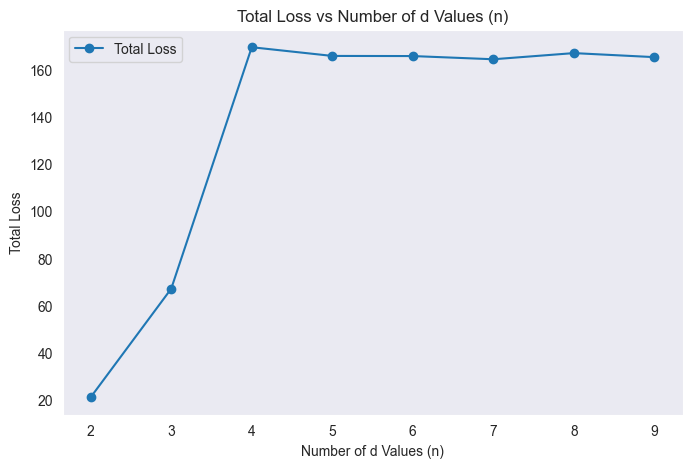

In [9]:
# plot your amount of loss and number of d in datasets
# TODO
plt.figure(figsize=(8, 5))
plt.plot(range(2, 10), losses, marker='o', label="Total Loss")
plt.title("Total Loss vs Number of d Values (n)")
plt.xlabel("Number of d Values (n)")
plt.ylabel("Total Loss")
plt.grid()
plt.legend()
plt.show()

# Write your opinion

+ You can see, as the number of d in the sequences increases the amount of the total loss increases too. Why?
    - `your answer`

+ Can you mathematically explain your opinion? (help: There are some gradient issues!)
    - `your answer`

+ Can you explain the problem of Long-term dependencies in RNNs?
    - `your answer`

# Gated Recurrent Units (GRUs) (30 points)

Step3. In the previous section, you saw, simple recurrent models cannot remember information from the past. This is a big problem because in real-world applications sequences have a lot of dependencies on their past time steps and we have to find a way to remember the information from the past. To address this problem, researchers have designed other architecture that can selectively remember or forget information over time. Like: `Long-Short Term Memory (LSTM)` and `Gated Recurrent Unit (GRU)`. The key building block behind these architectures is `gate`.

#### GATE:
These networks, use gates to track information throughout many time steps:
+ Add information, when the information is needed.
+ Remover information, When information is not important

<img src="GATE.jpg" width="400" height="200">

#### Long-Short Term Memory:
LSTM is an improved version of RNNs. In a classical recurrent model, there is a single hidden state `h` which is used to help the model to remember some information over time. But this is not enough to learn long-term dependencies. Using gates, LSTM is capable of addressing the problem of long-term dependencies. 

LSTM cell:

<img src="LSTM.jpg" width="400" height="200">

GATES:
+ <font color=green size=3> Forget gate:</font> To forget irrelevant information.
+ <font color=red size=3> Store gate:</font> Decide what part of new is relevant.
+ <font color=orange size=3> Update:</font> update cell state values.
+ <font color=blue size=3> Output gate:</font> Controls what information is sent to the next time step.
 
This architecture addresses the gradient issues you have described in the previous section. (How?)

`write your answer`

#### Gated Recurrent Unit (GRU):
Like LSTM, GRU is designed to model sequential data by allowing information to be selectively remembered or forgotten over time.

GRU cell:

<img src="GRU.jpg" width="400" height="200">

GATES and other parts:
+ <font color=green size=3> Reset gate:</font> How much of previous hidden state to forget.
    - $r_t = \sigma(W_r \cdot [h_{t-1}, x_t])$
+ <font color=orange size=3> Update gate:</font> How much of the candidate activation vector to incorporate into the new hidden state.
    - $z_t = \sigma(W_z \cdot [h_{t-1}, x_t])$
    
+ <font color=red size=3> Candidate Activation vector:</font> Computed using the current input x and modified version of the previous hidden state that is `reset` by the reset gate.
    - $\tilde{h}_t = \tanh(W_h \cdot [r_t \odot h_{t-1}, x_t])$

+ <font color=blue size=3> Hidden state</font>
    - $h_t = (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t$

Note: the $W_r$, $W_z$, $W_h$ are the weights associated with the GRU cell.

# GRU Implementation
Now, implement a Gated Recurrent Unit from scratch.

In [10]:
class GRU_cell(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_calsses):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_classes = num_calsses

        self.reset_gate = nn.Linear(self.input_dim + self.hidden_dim, self.hidden_dim)
        self.update_gate = nn.Linear(self.input_dim + self.hidden_dim, self.hidden_dim)
        self.candidate = nn.Linear(self.input_dim + self.hidden_dim, self.hidden_dim)
        
        self.output = nn.Linear(self.hidden_dim, self.num_classes)
        
        # TODO
        # define activation functions
        
    def forward(self, x, h, end = False):
        # TODO 
        # (reset gate, update gate, candidate vector, hidden state, output)
        # feel free to change the input parameter
        pass

# MNIST 
MNIST database is a collection of handwritten digits. You are going to use this database to train and test your GRU cell.

First, to download this database run the cell below.

In [11]:
database = MNIST(root = 'data/', download = True)
# TODO
# get train and test data - use transforms.ToTensor() to convert images to tensor
train_data = 
test_data = 

SyntaxError: invalid syntax (2723446608.py, line 4)

Show the image and label of one instance from the train data.

In [ ]:
# TODO

In [ ]:
# TODO
# show one image tensor

### Write a generate custom dataset function
+ For each data in the database convert, use one-hot encoding from pytorch to encode your label to a vector. This is necessary for computing the amount of loss.
+ It is common to use batches of data to train our model simultaneously on a batch. The length of a batch at most is `BATCH_SIZE`.
    - Note: you can also train your model on each data (one by one) but the training part will take too much time. 
+ Return batches of data.

In [ ]:
HIDDEN_DIM = 15
INPUT_DIM = 28
NUM_CLASSES = 10
BATCH_SIZE = 128
EPOCHS = 30

In [ ]:
def CustomDataset(data, batch_size = BATCH_SIZE):
    """ 
        Generate batches of data. Use one-hot encoding to encode your labels according to number of classes.
        
        Parameters:
            - data: MNIST database
            - batch_size = BATCH_SIZE

        Returns:
            - batches = A list of [(image_tensor, encoded label)]. Each batch's length is at most BATCH_SIZE
    """
    batches = []
    
    for image_tensor, label in data:
        encoded_label = # use one-hot encoding
        encoded_label = torch.tensor(encoded_label, dtype=torch.float32).unsqueeze(dim = 0)
        # TODO

    return batches

### Training loop
write your training loop.
+ For loss function: use `CrossEntropyLoss` function
+ Use adam optimizer
+ To optimize your training process, you can use `optim.lr_schduler`. (Why this will improve the training process?)
    - `your answer`
+ Note: Also, in each time step give one row of image tensor to the model because your model is sequential (you also can use each column).

In [ ]:
# TODO
# create batches
batches = CustomDataset(train_data)

# Initialize model, loss function, and optimizer
model = GRU_cell(INPUT_DIM, HIDDEN_DIM, NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# use scheduler to set learning rate

# training loop
# TODO
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for x, y in batches:


### Test your model on Test data
Use the test data to evaluate your model.
+ Print the accuracy of your model (should be greater than $94\%$).
+ Show some predictions with actual value from the test data.

In [ ]:
model.eval()
with torch.no_grad():
    # compute the accuracy of your model
    # TODO
    count = 0
    dataset = CustomDataset(test_data)

    for x, y in dataset:
        # TODO
        pass
    

In [ ]:
# show images of 50 predictions with actual values 